In [1]:
import pandas as pd
import quandl as qd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cross_validation
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import PyQt5
from sklearn.neural_network import MLPRegressor
import tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense

/home/nishchal/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
df = qd.get("NSE/POWERGRID", authtoken="gmWv5h5b4KEUxUbiSneX")

In [3]:
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2007-10-05,89.8,109.50,83.15,100.20,100.60,481058927.0,493056.07
2007-10-08,104.0,104.00,94.85,95.30,95.45,71252858.0,69916.16
2007-10-09,95.5,102.85,90.35,102.10,101.95,65658228.0,64717.84
2007-10-10,104.6,105.00,102.00,102.65,102.90,38211410.0,39608.87
2007-10-11,120.0,120.00,102.00,114.85,114.40,59805552.0,66252.35


In [4]:
df.index

DatetimeIndex(['2007-10-05', '2007-10-08', '2007-10-09', '2007-10-10',
               '2007-10-11', '2007-10-12', '2007-10-15', '2007-10-16',
               '2007-10-17', '2007-10-18',
               ...
               '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08',
               '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14',
               '2018-06-15', '2018-06-18'],
              dtype='datetime64[ns]', name='Date', length=2651, freq=None)

In [5]:
df.dropna(inplace=True)

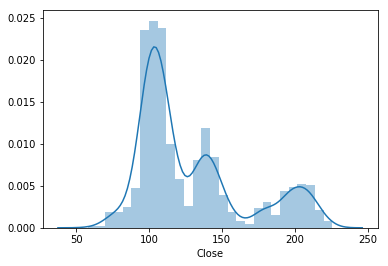

In [6]:
plt.figure(2)
sns.distplot(df.Close)
plt.show()

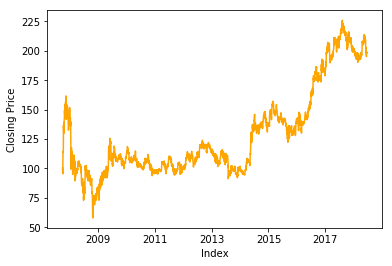

In [7]:
plt.figure(3)
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.plot(df.Close, color='orange')
plt.show()

In [8]:
def RSI(dataframe, period):
    delta = dataframe.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)
df_temp = df[['Open', 'High', 'Low', 'Close', 'Total Trade Quantity']]
df_temp['HLP'] = (df_temp['High'] - df_temp['Close']) / df_temp['Close'] * 100.0
df_temp['Change'] = (df_temp['Close'] - df_temp['Open']) / df_temp['Open'] * 100
#df_temp['EPS'] = (df['Turnover (Lacs)']*100000)/df['Total Trade Quantity']
#df_temp['PE'] = df_temp['Close']/df_temp['EPS']
df_temp['EWMA12']= pd.ewma(df_temp['Close'], span=12)
df_temp['EWMA26']= pd.ewma(df_temp['Close'], span=26)
df_temp['MACD']= (df_temp['EWMA12'] - df_temp['EWMA26'])
df_temp['RSI']= RSI(df_temp['Close'],6)
def getclass(int):
    if(int < 0):
        return 0
    else:
        return 1
        
df_temp['Class']= df_temp['Change'].apply(getclass)
df_use = df_temp[['Close', 'HLP', 'Change', 'Total Trade Quantity', 'EWMA12','EWMA26','MACD', 'RSI', 'Class']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,adjust=True,ignore_na=False,min_periods=0).mean()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,adjust=True,ignore_na=False,min_periods=0).mean()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Seri

In [9]:
df_use.head()

,Close,HLP,Change,Total Trade Quantity,EWMA12,EWMA26,MACD,RSI,Class
Date,,,,,,,,,
2007-10-05,100.60,8.846918,12.026726,481058927.0,100.600000,100.600000,0.000000,NaN,1
2007-10-08,95.45,8.957569,-8.221154,71252858.0,97.810417,97.925962,-0.115545,NaN,0
2007-10-09,101.95,0.882786,6.753927,65658228.0,99.426097,99.371759,0.054338,NaN,1
2007-10-10,102.90,2.040816,-1.625239,38211410.0,100.522672,100.358101,0.164571,NaN,0
2007-10-11,114.40,4.895105,-4.666667,59805552.0,104.293093,103.614476,0.678617,NaN,0


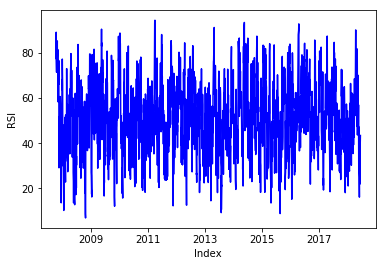

In [10]:
plt.figure(4)
plt.xlabel('Index')
plt.ylabel('RSI')
plt.plot(df_use.RSI, color='blue')
plt.show()

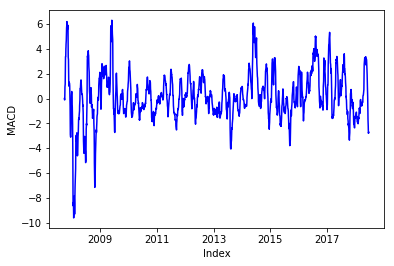

In [11]:
plt.figure(5)
plt.xlabel('Index')
plt.ylabel('MACD')
plt.plot(df_use.MACD, color='blue')
plt.show()


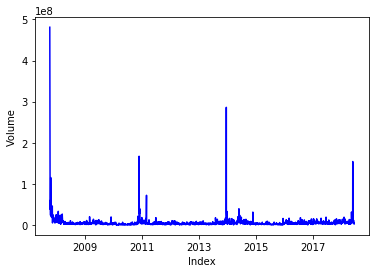

In [12]:

plt.figure(5)
plt.xlabel('Index')
plt.ylabel('Volume')
plt.plot(df_use['Total Trade Quantity'], color='blue')
plt.show()

In [13]:
forecast_col = 'Close'

forecast_out = 8

df_use['Label'] = df_use[forecast_col].shift(-forecast_out)

df_pred = df_use[-8:]

df_use.dropna(inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
print('We are predicting "', forecast_out, '" days into the future')

We are predicting " 8 " days into the future


In [15]:
X = df_use.drop(['Label'], 1)

Y = df_use['Label']
print(X.shape, Y.shape)

(2637, 9) (2637,)


In [16]:
y_norm= preprocessing.scale(Y.values)
x_norm = preprocessing.scale(X.values)

In [17]:
print(y_norm)
x_norm

[0.20974656 0.31909631 0.39510772 ... 1.86999577 1.8433251  1.86466164]


array([[-0.35876412, -0.0706236 , -0.33453622, ...,  0.4689692 ,
         1.63581234, -0.95657341],
       [-0.0437563 ,  0.08938646,  5.10024392, ...,  0.81067625,
         2.11671675,  1.04539808],
       [ 0.22165455,  0.62035838, 10.10492271, ...,  1.27712321,
         2.35091465,  1.04539808],
       ...,
       [ 1.9615701 ,  0.80383032, -1.24293834, ..., -0.04359462,
        -1.88680803, -0.95657341],
       [ 1.88516394, -0.20241706, -0.45455484, ..., -0.41469254,
        -2.15410661, -0.95657341],
       [ 1.94548459, -0.26331889,  0.95224338, ..., -0.61285818,
        -1.28859677,  1.04539808]])

In [18]:
y_norm

array([0.20974656, 0.31909631, 0.39510772, ..., 1.86999577, 1.8433251 ,
       1.86466164])

In [19]:
rows=x_norm.shape[0]
a=int(rows*0.80)
X_train=x_norm[:a]
Y_train=y_norm[:a]
X_test=x_norm[a:]
Y_test=y_norm[a:]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2109, 9) (2109,)
(528, 9) (528,)


In [20]:
y_orig = df['Close'][-8:].iloc[:].values

In [21]:
y_orig_mean = y_orig.mean(axis = 0)
y_orig_std = y_orig.std(axis = 0)


In [22]:
clf1 = svm.SVR(kernel = 'rbf', gamma = 0.0001, C = 1000, epsilon = 0.001)

clf1.fit(X_train, Y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
clf1.score(X_test, Y_test)

0.8790846293141485

In [24]:
y_orig_scale = preprocessing.scale(y_orig)
y_orig_scale

array([ 2.13759192, -0.09794896, -1.11200873, -1.4116173 ,  0.01728511,
        0.33994049, -0.12099577,  0.24775324])

In [25]:
x_pred = preprocessing.scale(df_pred.drop(['Label'], 1))
y_pred_clf1  = clf1.predict(x_pred)
y_pred_clf1

array([ 1.88102951,  0.21743446, -0.63557383, -1.05043879, -0.12757031,
        0.03862656, -0.35541903, -0.15790587])

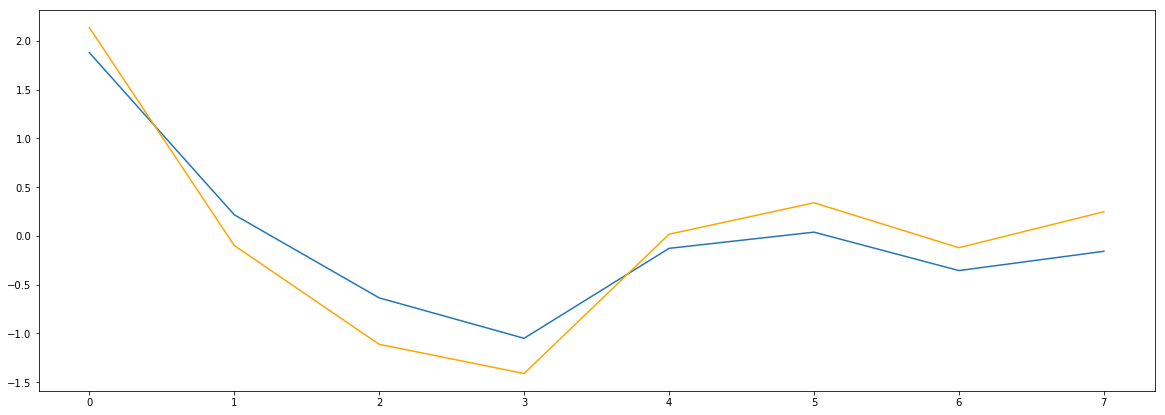

In [26]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax.plot(y_pred_clf1)
ax.plot(y_orig_scale, color='orange')

In [27]:
y_new_clf1 = (y_pred_clf1*y_orig_std) + y_orig_mean
y_new_clf1

array([202.19338854, 198.58422349, 196.73362427, 195.83357583,
       197.83573654, 198.19630022, 197.34141936, 197.76992362])

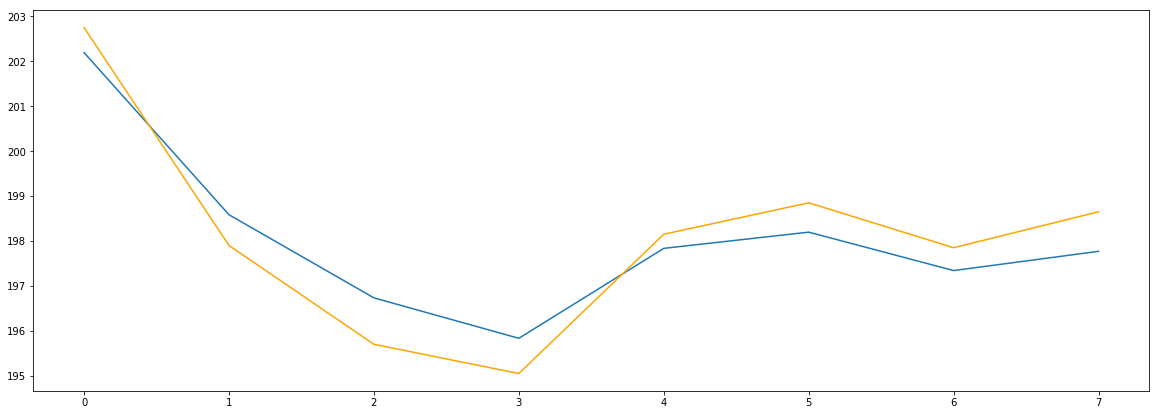

In [28]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax.plot(y_new_clf1)
ax.plot(y_orig, color='orange')

In [29]:
neu = MLPRegressor(hidden_layer_sizes = 1000, activation = 'tanh', solver = 'lbfgs' , alpha=0.001, 
                   batch_size = 100, learning_rate = 'adaptive')

In [30]:
neu.fit(X_train, Y_train)

MLPRegressor(activation='tanh', alpha=0.001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [31]:
neu.score(X_test, Y_test)

0.8444826777670393

In [32]:
x_pred = preprocessing.scale(df_pred.drop(['Label'], 1))
y_pred_neu  = neu.predict(x_pred)
y_pred_neu

array([ 1.90839189,  0.06429383, -0.80901797, -1.16537269, -0.07424924,
        0.15157622, -0.26602532, -0.01547487])

In [33]:
y_orig

array([202.75, 197.9 , 195.7 , 195.05, 198.15, 198.85, 197.85, 198.65])

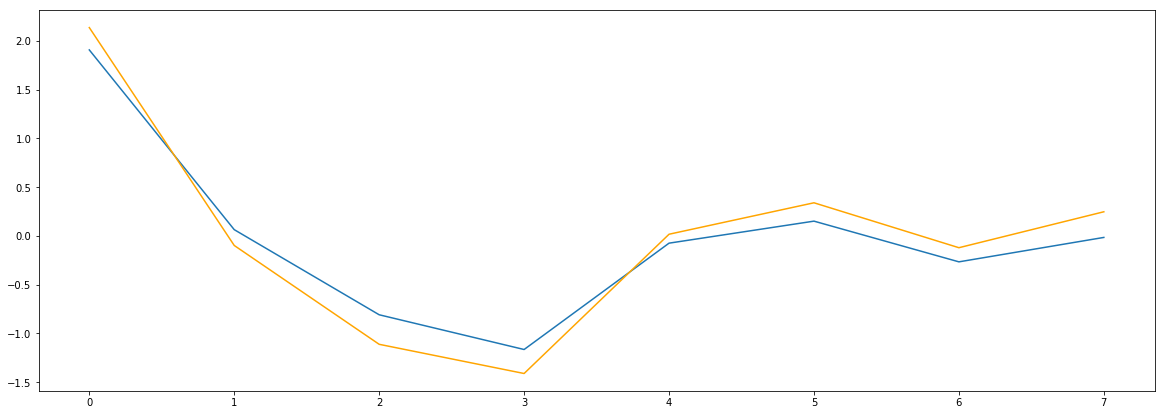

In [34]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax.plot(y_pred_neu)
ax.plot(y_orig_scale, color='orange')

In [35]:
y_new_neu = (y_pred_neu*y_orig_std) + y_orig_mean
y_new_neu

array([202.25275115, 198.2519853 , 196.35733766, 195.58422703,
       197.95141647, 198.44134421, 197.53535876, 198.07892732])

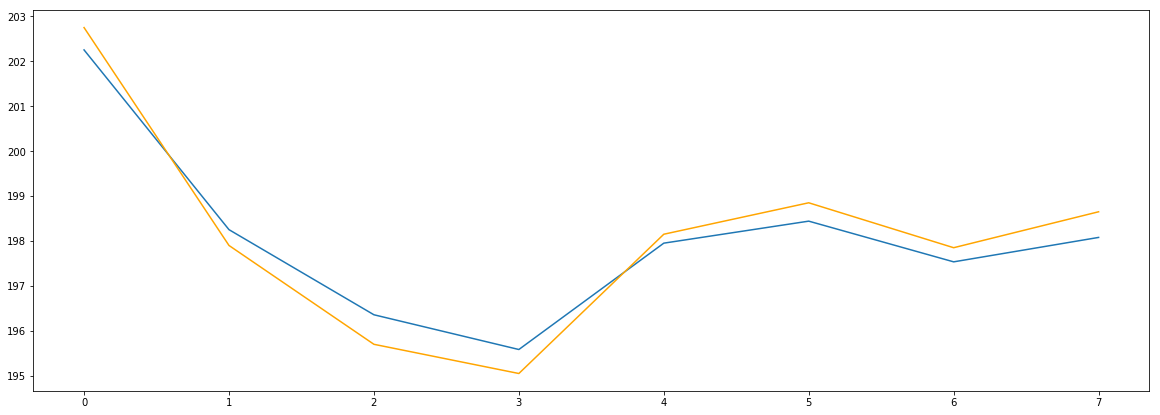

In [36]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax.plot(y_new_neu)
ax.plot(y_orig, color='orange')

In [37]:
model = Sequential()

In [38]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [43]:
model.add(LSTM(4, input_shape=(1, 9), return_sequences = False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=2)

ValueError: Input 0 is incompatible with layer lstm_5: expected ndim=3, found ndim=2

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=32)